In [1]:
from __future__ import division, print_function
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import GPyOpt
from torch.autograd import Variable
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from scipy.stats import norm
from matplotlib import animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

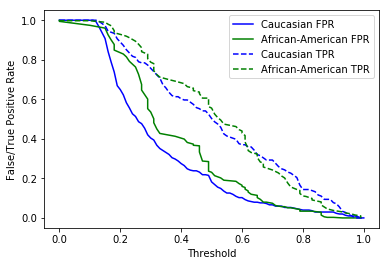

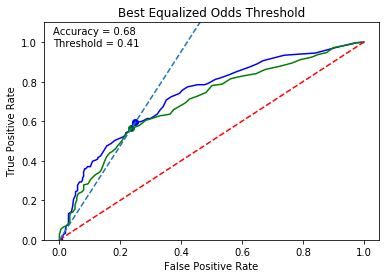

interactive(children=(IntSlider(value=49, description='j', max=86, min=12), Output()), _dom_classes=('widget-i…

In [123]:
def normalize(data, norm_type):
    if norm_type == "minmax":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].min()) / (data[:,i].max()-data[:,i].min())
        return data
    elif norm_type == "zscore":
        for i in range(data.size()[1]):
            data[:,i] = (data[:,i]-data[:,i].mean()) / (data[:,i].std())
        return data
    elif norm_type == None:
        return data
    else:
        raise ValueError("Please choose a correct normalization type")
#Xnumtrain = torch.tensor(np.vstack([(Xnumtrain[:,i]-Xnumtrain[:,i].min()) / (Xnumtrain[:,i].max()-Xnumtrain[:,i].min()) for i in range(Xnumtrain.size()[1]) if "Tue elsker det her"])).view(-1,2)

def dataprep(data, norm_type = "zscore"):
    for category in categoricals:
        data[category] = data[category].astype("category")

    catdata = []
    for i in range(len(categoricals)):
        catdata.append(data[categoricals[i]].cat.codes.values)
    catdata = torch.tensor(catdata, dtype = torch.int64).T
    
    
    numdata = np.stack([data[col].values for col in numericals], 1)
    numdata = torch.tensor(numdata, dtype=torch.float)

    normalize(numdata, norm_type)
    return catdata, numdata

def permutation(data, cat):
    perm_data = data.copy()
    rand_num = np.random.permutation(perm_data.index)
    perm_data[cat][perm_data.index] = data[cat][rand_num] 
    df = perm_data
    return df

def reset_data():
    return pd.read_csv("https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv")


def make_dat(url,shuffle=False):
    if shuffle == True:
        df = pd.read_csv(url)
        return df.reindex(np.random.permutation(df.index))
    else:
        return pd.read_csv(url)

def perm_test_model(permutations):
    acc_scores = []
    for t in range(permutations):
        perm_Xcattest = np.copy(Xcattest)
        perm_Xnumtest = np.copy(Xnumtest)
        for i in range(Xcattest.size()[1]):
            rand_num_cat = np.random.randint(0 , Xcattest.size()[0] , Xcattest.size()[0])
            rand_num_num = np.random.randint(0 , Xnumtest.size()[0] , Xnumtest.size()[0])
            for j in range(Xcattest.size()[0]):
                perm_Xcattest[j, i] = Xcattest[rand_num_cat[j],i]
                perm_Xnumtest[j, i] = Xnumtest[rand_num_num[j],i]
        perm_Xcattest = torch.tensor(perm_Xcattest , dtype=torch.long)
        perm_Xnumtest = torch.tensor(perm_Xnumtest , dtype=torch.float)
        model.eval()
        y_val = model(perm_Xcattest, perm_Xnumtest) 
        y_pred = (y_val > threshold).float()
        acc_scores.append(accuracy_score(ytest, y_pred))
    return acc_scores

class Classification():
    
    def __init__(self, xtrain, ytrain, classification_model):
        # Classification_model = [GaussianNB(), LogisticRegression(), RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "log2", criterion = "entropy")]
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.model = classification_model
        self.model.fit(self.xtrain, self.ytrain)
        
    def Validate(self, model, datatest, ytest, show_acc = True):
        # Predict on the test set
        self.preds = model.predict(datatest)
        self.probs = model.predict_proba(datatest)[:, 1]
        self.acc = accuracy_score(ytest, self.preds)
        self.conf = confusion_matrix(ytest, self.preds)
        self.conf_norm = np.copy(self.conf).astype(float)
        for i in range(2):
            self.conf_norm[i,:] = self.conf[i,:] / np.sum(conf, axis = 1)[i]
        
        if show_acc:
            print("Accuracy of the model: ", self.acc)
            print(self.conf)
            print(self.conf_norm)
            print()
            
    def FeatureImportance(self, model):
        importances = list(model.feature_importances_)

        # List of tuples with variable and importance
        self.feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]

        # Sort the feature importances by most important first
        self.feature_importances = sorted(self.feature_importances, key = lambda x: x[1], reverse = True)

        # Print out the feature and importances 
        [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in self.feature_importances]


        # List of features sorted from most to least important
        sorted_importances = [importance[1] for importance in self.feature_importances]
        sorted_features = [importance[0] for importance in self.feature_importances]
        # list of x locations for plotting
        x_vals = list(range(len(importances)))
        # Make a bar chart
        plt.bar(x_vals, sorted_importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
        # Tick labels for x axis
        plt.xticks(x_vals, sorted_features, rotation='vertical')
        # Axis labels and title
        plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');
        plt.show()


        # Cumulative importances
        cumulative_importances = np.cumsum(sorted_importances)
        # Make a line graph
        plt.plot(x_vals, cumulative_importances, 'g-')
        # Draw line at 95% of importance retained
        plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances)-1, color = 'r', linestyles = 'dashed')
        # Format x ticks and labels
        plt.xticks(x_vals,sorted_features, rotation = 'vertical')
        # Axis labels and title
        plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')
        plt.show()


def BiasCorrection(points, probs1, probs2, true1, true2, min_threshold = 0.2, max_threshold = 0.8, max_diff = 0.001, show_scatter = True, show_plot = True, kind = "equalized odds"):
    points = points
    step = 1/points
    thresholds = np.arange(0,1+step,step)

    tprs1 = []
    fprs1 = []
    tprs2 = []
    fprs2 = []
    for i in range(points+1):
        y_pred1 = (probs1 > thresholds[i]).float()
        y_pred2 = (probs2 > thresholds[i]).float()
        conf1 = confusion_matrix(true1, y_pred1)
        conf2 = confusion_matrix(true2, y_pred2)

        tprs1.append(conf1[1,1] / (conf1[1,1] + conf1[1,0]))
        fprs1.append(conf1[0,1] / (conf1[0,1] + conf1[0,0]))
        tprs2.append(conf2[1,1] / (conf2[1,1] + conf2[1,0]))
        fprs2.append(conf2[0,1] / (conf2[0,1] + conf2[0,0]))

    # Find the thresholds with the same tpr and fpr
    tprdiff = []
    fprdiff = []
    thresholds1 = []
    thresholds2 = []

    for i in range(len(thresholds)):
        tprval1 = tprs1[i]
        fprval1 = fprs1[i]
        threshold1 = thresholds[i]
        tprindex2 = min(range(len(tprs2)), key=lambda x: abs(tprs2[x]-tprval1))
        threshold2 = thresholds[tprindex2]
        tprval2 = tprs2[tprindex2]
        fprval2 = fprs2[tprindex2]
        tprdiff.append(abs(tprval1 - tprval2))
        fprdiff.append(abs(fprval1 - fprval2))
        thresholds1.append(threshold1)
        thresholds2.append(threshold2)
        #print(tprval1, fprval1, threshold1, tprval2, fprval2, threshold2)
    
    if show_plot:
        plt.plot(thresholds1, fprs1, color = "blue", label = "Caucasian FPR")
        plt.plot(thresholds2, fprs2, color = "green", label = "African-American FPR")
        plt.plot(thresholds1, tprs1, "--", color = "blue", label = "Caucasian TPR")
        plt.plot(thresholds2, tprs2, "--", color = "green", label = "African-American TPR")
        plt.legend()
        plt.xlabel("Threshold")
        plt.ylabel("False/True Positive Rate")
        plt.show()
    
    if kind == "equalized odds":
        # Find the best accuracy that satisfies equalized odds
        num_excluded_points = int(points * 0.24)
        accs = []
        x1s = []
        x2s = []
        y1s = []
        y2s = []
        slopes = []
        for j in range(points - num_excluded_points + 1):

            # Find the index of the threshold of a point
            #point_idx = min(range(len(thresholds2)), key=lambda x: abs(thresholds2[x]-0.5))

            # Find the corrosponding tpr and fpr values and use this to make a line
            point_idx = int(j + num_excluded_points/2 + num_excluded_points/25)
            slope = tprs2[point_idx] / fprs2[point_idx]
            slopes.append(slope)
            
            # Sample points on this new line
            line = lambda x: slope * x

            # Find the intersection of the line and the upper curve
            np.set_printoptions(suppress=True)
            linediff = abs(tprs1 - line(np.asarray(fprs1, dtype = "float64")))
            intersection_index = np.argmin(linediff[line(np.asarray(fprs1, dtype = "float64")) > tprs2[point_idx]])

            x1 = fprs1[intersection_index]
            x2 = fprs2[point_idx]
            y1 = tprs1[intersection_index]
            y2 = tprs2[point_idx]
            
            x1s.append(x1)
            x2s.append(x2)
            y1s.append(y1)
            y2s.append(y2)
            
            # Find the lengths of the lines between 0,0 and the new point on the upper line
            thres1 = 1.0
            thres2 = thresholds1[intersection_index]
            full_length = np.sqrt(y1**2 + x1**2)
            first_length = np.sqrt(y2**2 + x2**2)
            second_length = full_length - first_length
            # Make the predictions
            sample_threshold = first_length / (first_length + second_length)
            y_pred1_low = (probs1 > thres1).float()
            y_pred1_high = (probs1 > thres2).float()
            y_pred1 = [None] * len(probs1)
            for i in range(len(y_pred1)):
                sample_value = np.random.uniform(0,1,1)
                if sample_value > sample_threshold:
                    y_pred1[i] = y_pred1_low[i]
                else:
                    y_pred1[i] = y_pred1_high[i]

            y_pred2 = (probs2 > thresholds2[point_idx]).float()
            accs.append((accuracy_score(true1, y_pred1) + accuracy_score(true2, y_pred2)) / 2)
        
        plt.plot(fprs1,tprs1,color="blue")
        plt.plot(fprs2,tprs2,color="green")
        x_values = [0, 1] 
        y_values = [0, 1]
        plt.plot(x_values, y_values,'--',color="red")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.ylim(0, 1.1)
        
        best_idx = np.argmax(accs)
        best_acc = accs[best_idx]
        x1 = x1s[best_idx]
        x2 = x2s[best_idx]
        y1 = y1s[best_idx]
        y2 = y2s[best_idx]
        slope = slopes[best_idx]
        plt.scatter(x1, y1, c = "blue")
        plt.scatter(x2, y2, c = "green")
        
        line = line = lambda x: slope * x
        plt.plot(np.linspace(0,1,points+1), line(np.linspace(0,1,points+1)), "--")
        
        plt.title("Best Equalized Odds Threshold")
        plt.text(-0.02, 0.98, f"Accuracy = {best_acc:.2f}\nThreshold = {thresholds2[best_idx]:.2f}")
        plt.show()
        

        def morePoints(j):
            plt.plot(fprs1,tprs1,color="blue")
            plt.plot(fprs2,tprs2,color="green")
            x_values = [0, 1] 
            y_values = [0, 1]
            plt.plot(x_values, y_values,'--',color="red")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.ylim(0, 1.1)

            # Find the corrosponding tpr and fpr values and use this to make a line
            point_idx = int(j + num_excluded_points/2)
            slope = tprs2[point_idx] / fprs2[point_idx]

            # Sample points on this new line
            line = lambda x: slope * x
            plt.plot(np.linspace(0,1,points+1), line(np.linspace(0,1,points+1)), "--")

            # Find the intersection of the line and the upper curve
            np.set_printoptions(suppress=True)
            linediff = abs(tprs1 - line(np.asarray(fprs1, dtype = "float64")))
            intersection_index = np.argmin(linediff[line(np.asarray(fprs1, dtype = "float64")) > tprs2[point_idx]])

            # Find the lengths of the lines between 0,0 and the new point on the upper line
            thres1 = 1.0
            thres2 = thresholds1[intersection_index]
            full_length = np.sqrt(tprs1[intersection_index]**2 + fprs1[intersection_index]**2)
            first_length = np.sqrt(tprs2[point_idx]**2 + fprs2[point_idx]**2)
            second_length = full_length - first_length
            # Make the predictions
            sample_threshold = first_length / (first_length + second_length)
            #sample_threshold = 0.5
            y_pred1_low = (probs1 > thres1).float()
            y_pred1_high = (probs1 > thres2).float()
            y_pred1 = [None] * len(probs1)
            for i in range(len(y_pred1)):
                sample_value = np.random.uniform(0,1,1)
                if sample_value > sample_threshold:
                    y_pred1[i] = y_pred1_low[i]
                else:
                    y_pred1[i] = y_pred1_high[i]

            y_pred2 = (probs2 > thresholds2[point_idx]).float()
            conf2 = confusion_matrix(true2, y_pred2)
            # Comparing to the true values
            conf1 = confusion_matrix(true1, y_pred1)

            yval = conf1[1,1] / (conf1[1,1] + conf1[1,0])
            xval = conf1[0,1] / (conf1[0,1] + conf1[0,0])
            plt.scatter(xval, yval, c="blue")
            plt.scatter(fprs2[point_idx], tprs2[point_idx], c="green")
            plt.title("Equalized Odds")
            plt.show()

            conf_norm1 = np.copy(conf1).astype(float)
            conf_norm2 = np.copy(conf2).astype(float)
            conf_norm1 = conf1 / np.sum(conf1)
            conf_norm2 = conf2 / np.sum(conf2)
            #print(conf_norm1)
            #print(conf_norm2)
            acc = (accuracy_score(true1, y_pred1) + accuracy_score(true2, y_pred2)) / 2
            print(acc)
            print(max(accs))

        interact(morePoints, j = (int(0 + num_excluded_points/2), int(points - num_excluded_points/2 - 2)))
    elif kind == "equal opportunity":
        accs = []
        new_thres1 = []
        new_thres2 = []
        x1s = []
        x2s = []
        y1s = []
        y2s = []
        for point in range(points + 1):
            
            y2 = tprs2[point]
            ydiff = abs(y2 - tprs1)
            intersection_idx = np.argmin(ydiff)
            y1 = tprs1[intersection_idx]
            x2 = fprs2[point]
            x1 = fprs1[intersection_idx]
            
            x1s.append(x1)
            x2s.append(x2)
            y1s.append(y1)
            y2s.append(y2)
            
            thres1 = thresholds1[intersection_idx]
            thres2 = thresholds2[point]
            new_thres1.append(thres1)
            new_thres2.append(thres2)

            y_pred1 = (probs1 > thres1).float()
            y_pred2 = (probs2 > thres2).float()
            accs.append((accuracy_score(true1, y_pred1) + accuracy_score(true2, y_pred2)) / 2)
        best_idx = np.argmax(accs)
        best_acc = accs[best_idx]
        best_thres1 = new_thres1[best_idx]
        best_thres2 = new_thres2[best_idx]
        
        # Plotting of the basics
        plt.plot(fprs1,tprs1,color="blue")
        plt.plot(fprs2,tprs2,color="green")
        x_values = [0, 1] 
        y_values = [0, 1]
        plt.plot(x_values, y_values,'--',color="red")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.ylim(0, 1.1)

        # Plotting of the points with equal tpr and finding accuracy for these thresholds
        x1 = x1s[best_idx]
        x2 = x2s[best_idx]
        y1 = y1s[best_idx]
        y2 = y2s[best_idx]
        plt.scatter(np.array([x1,x2]), np.array([y1,y2]), color = ["blue", "green"])
        if x1 > x2:
            xline = np.linspace(x2, x1, num = 2)
        else:
            xline = np.linspace(x1, x2, num = 2)
        yline = np.asarray([y2] * len(xline))
        plt.plot(xline, yline, "--", color = "red")
        
        plt.title("Best Equal Opportunity Threshold")
        plt.text(-0.02, 0.93, f"Accuracy = {best_acc:.2f}\nThreshold 1 = {best_thres1:.2f}\nThreshold 2 = {best_thres2:.2f}")
        plt.show()
        
        
                    
    
BiasCorrection(100, y_val_white, y_val_black, y_white, y_black, show_scatter = True, show_plot = True, kind = "equalized odds")

# Data Visualization and Pre-processing

In [3]:
url = "https://raw.githubusercontent.com/oskarwiese/fagprojekt/master/compas_propublica/compas-scores-two-years.csv"
data = make_dat(url,shuffle=False)
data = data[(data["race"] == "Caucasian") | (data["race"] == "African-American")]

use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")
#print(data.columns)

No GPU available.


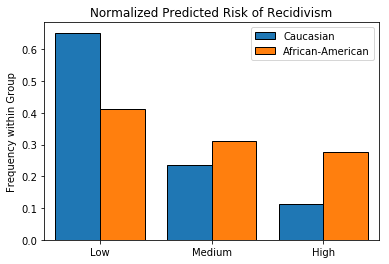

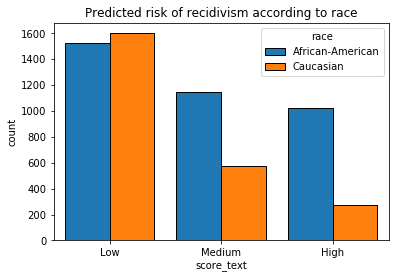

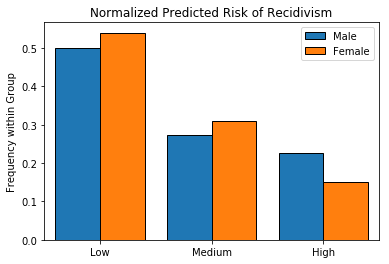

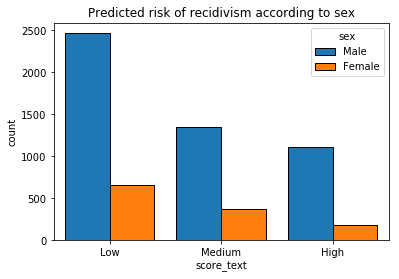

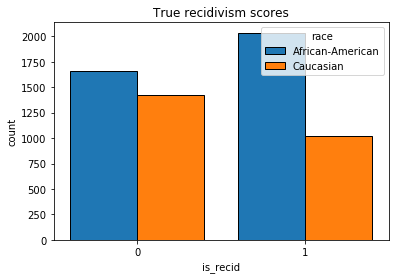

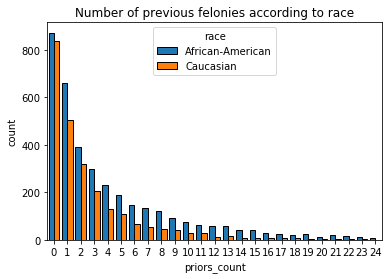

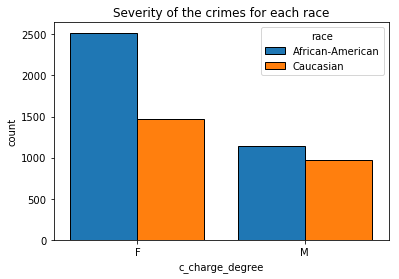

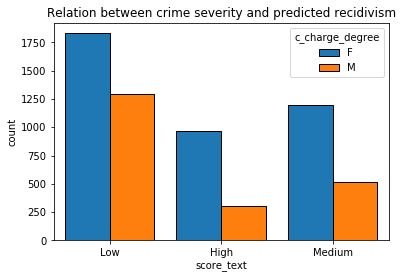

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


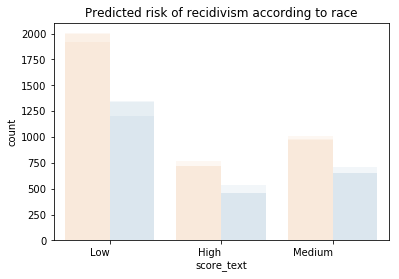

In [4]:
def is_plot(data):
    
    # Show the distributions of the black and white in the categories of score_text
    race_score_vals = ["Low", "Medium", "High"]
    race_vals = ["Caucasian", "African-American"]
    race_distribution = np.empty([2,3])
    for i, race in enumerate(race_vals):
        for j, score in enumerate(race_score_vals):
            race_distribution[i,j] = len(data[(data["race"] == race) & (data["score_text"] == score)]) / len(data[data["race"] == race])
    
    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
    
    # Shows distribution of black and white within score_text
    race_distribution = race_distribution.flatten()
    hue = ["Caucasian","Caucasian","Caucasian","African-American","African-American","African-American"]
    sb.barplot(["Low","Medium","High","Low","Medium","High"], race_distribution, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
    plt.ylabel("Frequency within Group")
    plt.title("Normalized Predicted Risk of Recidivism")
    plt.show()
    
    pred_plot_race = sb.countplot(x = "score_text", order = ['Low', 'Medium', 'High'], hue = "race", data = data, edgecolor=(0,0,0), linewidth=1, saturation = 1)                
    pred_plot_race.set_title("Predicted risk of recidivism according to race")
    #pred_plot_race.figure.savefig(path + "\\predicted_recid_race.png")
    plt.show()
    
    
    # Show the distributions of the male and female in the categories of score_text
    sex_score_vals = ["Low", "Medium", "High"]
    sex_vals = ["Male", "Female"]
    sex_distribution = np.empty([2,3])
    for i, sex in enumerate(sex_vals):
        for j, score in enumerate(sex_score_vals):
            sex_distribution[i,j] = len(data[(data["sex"] == sex) & (data["score_text"] == score)]) / len(data[data["sex"] == sex])

    path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"

    # Shows distribution of black and white within score_text
    sex_distribution = sex_distribution.flatten()
    hue = ["Male","Male","Male","Female","Female","Female"]
    sb.barplot(["Low","Medium","High","Low","Medium","High"], sex_distribution, hue = hue, edgecolor=(0,0,0), linewidth=1, saturation = 1)
    plt.ylabel("Frequency within Group")
    plt.title("Normalized Predicted Risk of Recidivism")
    plt.show()
    
    pred_plot_sex = sb.countplot(x = "score_text", order = ['Low', 'Medium', 'High'], hue = "sex", data = data, edgecolor=(0,0,0), linewidth=1, saturation = 1)
    pred_plot_sex.set_title("Predicted risk of recidivism according to sex")
    #pred_plot_sex.figure.savefig(path + "\\predicted_recid_sex.png")
    plt.show()
    
    true_plot = sb.countplot(x = "is_recid", hue = "race", data = data, edgecolor=(0,0,0), linewidth=1, saturation = 1)
    true_plot.set_title("True recidivism scores")
    #true_plot.figure.savefig(path + "\\true_recid.png")
    plt.show()
    
    df = data[(data["race"] == "African-American") | (data["race"] == "Caucasian")]
    df = df[df["priors_count"] < 25]
    
    priors_plot = sb.countplot(x = "priors_count", hue = "race", data = df, edgecolor=(0,0,0), linewidth=1, saturation = 1)
    priors_plot.set_title("Number of previous felonies according to race")
    #priors_plot.figure.savefig(path + "\\proirs.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "c_charge_degree", hue = "race", data = df, edgecolor=(0,0,0), linewidth=1, saturation = 1)
    c_charge_degree.set_title("Severity of the crimes for each race")
    #c_charge_degree.figure.savefig(path + "\\c_charge_degree.png")
    plt.show()
    
    c_charge_degree = sb.countplot(x = "score_text", hue = "c_charge_degree", data = df, edgecolor=(0,0,0), linewidth=1, saturation = 1)
    c_charge_degree.set_title("Relation between crime severity and predicted recidivism")
    #c_charge_degree.figure.savefig(path + "\\charge_degree_score.png")
    plt.show()
    
    palette = {"Caucasian": "C0", "African-American": "C1"}
    for i in tqdm(range(3)):
        #TODO: der skal indsættes punkter for den rigtige data1fordelling. 
        data = permutation(data, "race")
        path = r"C:\Users\ejer\Desktop\Fagprojekt\fagprojekt\report\imgs"
        pred_plot_race = sb.countplot(x = "score_text" ,hue = "race", data = data, palette = palette ,alpha=.06,  hue_order = [ "African-American","Caucasian"])
        pred_plot_race.set_title("Predicted risk of recidivism according to race")
        pred_plot_race.set_xticklabels(pred_plot_race.get_xticklabels(), horizontalalignment ='right')
        pred_plot_race.get_legend().remove()
        data = reset_data()
    plt.show()
    
is_plot(data)

In [5]:
categoricals = ["c_charge_degree", "race", "age_cat", "sex"]                # "r_charge_degree"    "two_year_recid"    "is_recid", "is_violent_recid"
numericals = ["age", "priors_count", "juv_fel_count", "juv_misd_count"]     # "days_b_screening_arrest"

outputs = ["score_text"]
features = categoricals + numericals
data = data[features + outputs + ["two_year_recid"] + ["is_recid"]]

# Making the output binary
data[outputs] = data[outputs].replace('Low',0)
data[outputs] = data[outputs].replace('Medium',1)
data[outputs] = data[outputs].replace('High',1)
data[outputs] = data[outputs].astype("category")

In [6]:
Xcat, Xnum = dataprep(data, norm_type = "zscore")

# Converting the output to tensor
y = torch.tensor(data[outputs].values).flatten()

# Calculation of embedding sizes for the categorical values in the format (unique categorical values, embedding size (dimension of encoding))
categorical_column_sizes = [len(data[column].cat.categories) for column in categoricals]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

# Train-test split
totalnumber = len(Xnum)
testnumber = int(totalnumber * 0.2)

Xcattrain = Xcat[:totalnumber - testnumber]
Xcattest = Xcat[totalnumber - testnumber:totalnumber]
Xnumtrain = Xnum[:totalnumber - testnumber]
Xnumtest = Xnum[totalnumber - testnumber:totalnumber]
ytrain = y[:totalnumber - testnumber]
ytest = data["is_recid"][totalnumber - testnumber:totalnumber]
ytest = torch.tensor(ytest.values).flatten()


# Make sure that we dont validate on training data to compare if the algorithm is biased


normalize(Xnumtrain, "zscore");
normalize(Xnumtest, "zscore");

# Neural Network

In [7]:
class Model(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        self.batch_norm_num = nn.BatchNorm1d(num_numerical_cols)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols + num_numerical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))

        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical, x_numerical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x_numerical = self.batch_norm_num(x_numerical)
        x = torch.cat([x, x_numerical], 1)
        x = self.layers(x)
        return nn.functional.sigmoid(x)

# Train the Model

In [8]:
# Define and show the model
model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
if use_cuda:
    model.cuda()
print(model)
for param in model.parameters():
            param.requires_grad = True

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(2, 1)
    (2): Embedding(3, 2)
    (3): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm_num): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=32, out_features=64, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=64,

In [10]:
# Loss function and optimization
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-6)
threshold = 0.5
epochs = 100
np.random.seed(42)

epoch:   1 loss: 0.75038821
epoch:  26 loss: 0.65820307
epoch:  51 loss: 0.61434186
epoch:  76 loss: 0.60545582
epoch: 100 loss: 0.5875517726
[[492 123]
 [303 312]]
[[0.61886792 0.15471698]
 [0.69655172 0.71724138]]
              precision    recall  f1-score   support

           0       0.62      0.80      0.70       615
           1       0.72      0.51      0.59       615

    accuracy                           0.65      1230
   macro avg       0.67      0.65      0.65      1230
weighted avg       0.67      0.65      0.65      1230

0.6536585365853659


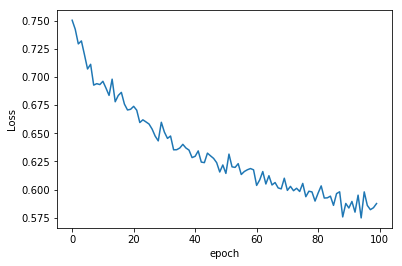

In [11]:
aggregated_losses = []

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

model.train()
for i in range(epochs):
    i += 1
    y_pred = model(Xcattrain, Xnumtrain)
    single_loss = loss_function(y_pred, ytrain.float())
    aggregated_losses.append(single_loss)

    if i % 25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')



# Plot the loss over epocs
if "plot":
    plt.plot(range(epochs), aggregated_losses)
    plt.ylabel('Loss')
    plt.xlabel('epoch');


# Predict on the test set
model.eval()
with torch.no_grad():
    y_val = model(Xcattest, Xnumtest)
    loss = loss_function(y_val, ytest.float())


y_pred = (y_val > threshold).float()


conf = confusion_matrix(ytest,y_pred)
conf_norm = np.copy(conf).astype(float)
for i in range(2):
    conf_norm[i,:] = conf[i,:] / np.sum(conf, axis = 0)[i]

neural_acc = accuracy_score(ytest, y_pred)
print(conf)
print(conf_norm)
print(classification_report(ytest,y_pred))
print(neural_acc)

# Permutation test for accuracy

In [16]:
acc_scores = perm_test_model(1000)

### Plot 

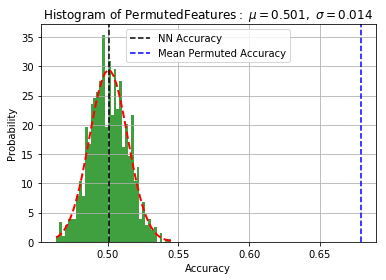

In [17]:
(mu, sigma) = norm.fit(acc_scores)
n, bins, patches = plt.hist(acc_scores,40, facecolor='green', alpha=0.75,density=True)
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.axvline(x=mu, color='k', linestyle='--', label = "NN Accuracy")
plt.axvline(x=accuracy_score(ytest, y_pred), color='b', linestyle='--', label = "Mean Permuted Accuracy")
plt.xlabel('Accuracy')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Permuted Features:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix for black/white

In [12]:
df = data[totalnumber - testnumber:totalnumber]
black_data = df[df["race"]=="African-American"]
white_data = df[df["race"]=="Caucasian"]
Xcat_white, Xnum_white = dataprep(white_data, norm_type = "zscore")
Xcat_black, Xnum_black = dataprep(black_data, norm_type = "zscore")
model.eval()
y_val_white = model(Xcat_white, Xnum_white)
y_pred1 = (y_val_white > threshold).float()
y_val_black = model(Xcat_black, Xnum_black)
y_pred2 = (y_val_black > threshold).float()

# Ground truth of recidivism from dataset
y_white = torch.tensor(white_data["two_year_recid"].values).flatten()
y_black = torch.tensor(black_data["two_year_recid"].values).flatten()

print("Confussion matrix for the white:")
conf_white = confusion_matrix( y_white, y_pred1)
conf_black = confusion_matrix( y_black, y_pred2)

conf_white_norm = np.copy(conf_white).astype(float)
conf_black_norm = np.copy(conf_black).astype(float)
for i in range(2):
    conf_white_norm[i,:] = conf_white[i,:] / np.sum(conf_white, axis = 1)[i]
    conf_black_norm[i,:] = conf_black[i,:] / np.sum(conf_black, axis = 1)[i]

print(conf_white)
print(conf_white_norm)
print()
print("Confussion matrix for the black:")
print(conf_black)
print(conf_black_norm)

#print(conf_white / conf_white.astype(np.float).sum(axis=1))
#print(conf_black / conf_black.astype(np.float).sum(axis=1))
#[0.21548821548821548, 0.3638968481375358] [0.5674157303370787, 0.6658227848101266]
#00 / 00 + 10
#01 / 01 + 00

Confussion matrix for the white:
[[247  55]
 [ 90  91]]
[[0.81788079 0.18211921]
 [0.49723757 0.50276243]]

Confussion matrix for the black:
[[276  75]
 [188 208]]
[[0.78632479 0.21367521]
 [0.47474747 0.52525253]]


* # Fede plots til fremtiden måske:


# Plots of the distribution of black and whites in each category of scoretext
sb.countplot(x = "score_text", data = black_data)
print(len(black_data[black_data["score_text"] == 0]))
print(len(black_data[black_data["score_text"] == 1]))
plt.show()
sb.countplot(x = "score_text", data = white_data)
print(len(white_data[white_data["score_text"] == 0]))
print(len(white_data[white_data["score_text"] == 1]))
plt.show()

# Baseline

In [13]:
def baseline(data):
    if len(data == 0) > len(data == 1):
        y_pred = [0] * len(data)
        y_pred = torch.tensor(y_pred)
    else:
        y_pred = [1] * len(data)
        y_pred = torch.tensor(y_pred)
    return y_pred

y_pred = baseline(ytest)
conf_baseline = confusion_matrix(ytest, y_pred)
print(conf_baseline)
print(conf_baseline / conf_baseline.astype(np.float).sum())
baseline_acc = accuracy_score(ytest, y_pred)
print(baseline_acc)
print("Accuracy difference", neural_acc - baseline_acc)
#print("Difference between baseline and neural network:", neural_acc - baseline_acc)

[[  0 615]
 [  0 615]]
[[0.  0.5]
 [0.  0.5]]
0.5
Accuracy difference 0.15365853658536588


# Neural Network Bias Correction

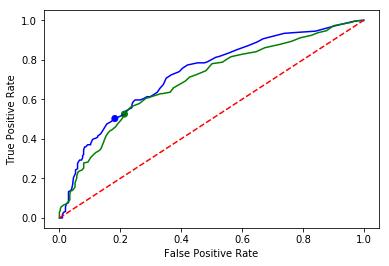

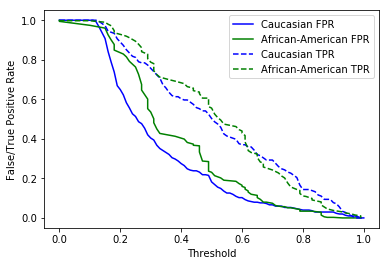

ValueError: attempt to get argmin of an empty sequence

In [14]:
BiasCorrection(100, y_val_white, y_val_black, y_white, y_black, show_scatter = True, show_plot = True)

[0.         0.33443709 1.        ] [0.         0.65745856 1.        ]


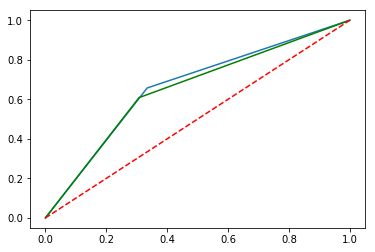

In [44]:
from sklearn import metrics
y_pred1 = (y_val_white > 0.5).float()
y_pred2 = (y_val_black > 0.5).float()
fpr, tpr, thresholds = metrics.roc_curve(y_white, y_pred1.view(-1),pos_label=1)
fpr2, tpr2, thresholds = metrics.roc_curve(y_black, y_pred2.view(-1),pos_label=1)
print(fpr,tpr)
plt.plot(fpr,tpr)
plt.plot(fpr2,tpr2,color="green")
x_values = [0, 1] 
y_values = [0, 1]
plt. plot(x_values, y_values,'--',color="red")
plt.show()

# Random Forest

In [45]:
rf_model = Classification(Xcattrain, ytrain, RandomForestClassifier(n_estimators = 52, max_depth = 14, max_features = "log2", criterion = "entropy"))
rf_model.Validate(rf_model.model, Xcattest, ytest)

# Test for bias
rf_white_test = Classification(Xcattrain, ytrain, RandomForestClassifier())
rf_black_test = Classification(Xcattrain, ytrain, RandomForestClassifier())
rf_white_test.Validate(rf_model.model, Xcat_white, y_white)
rf_black_test.Validate(rf_model.model, Xcat_black, y_black)

Accuracy of the model:  0.5902439024390244
[[313 302]
 [202 413]]
[[0.50894309 0.49105691]
 [0.32845528 0.67154472]]

Accuracy of the model:  0.6376811594202898
[[246  56]
 [119  62]]
[[0.4        0.09105691]
 [0.19349593 0.10081301]]

Accuracy of the model:  0.5515394912985274
[[ 83 268]
 [ 67 329]]
[[0.13495935 0.43577236]
 [0.10894309 0.53495935]]



# Random Forest Bias Correction

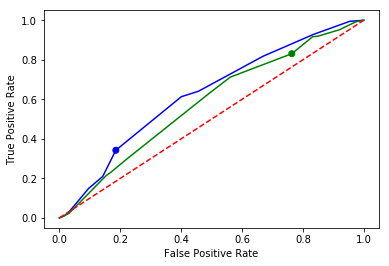

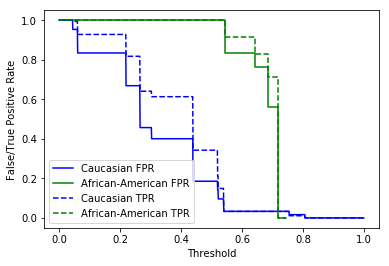

interactive(children=(IntSlider(value=499, description='j', max=991, min=8), Output()), _dom_classes=('widget-…

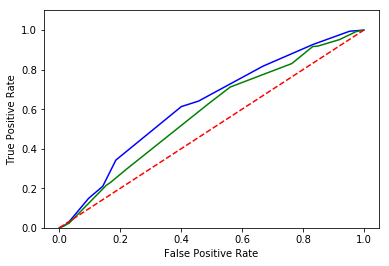

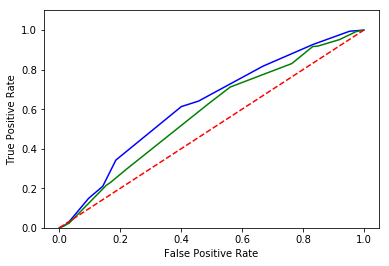

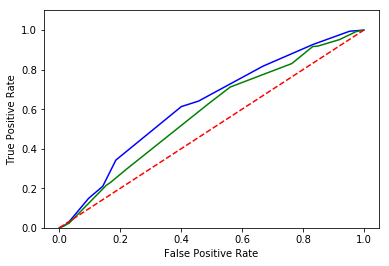

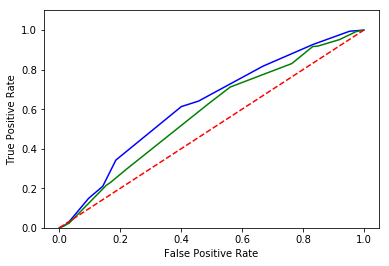

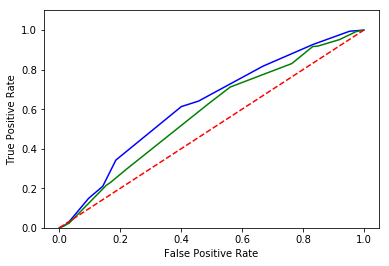

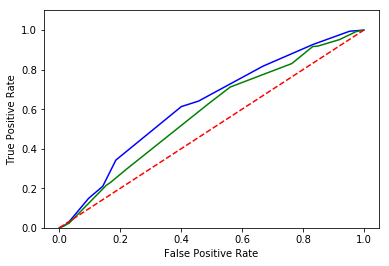

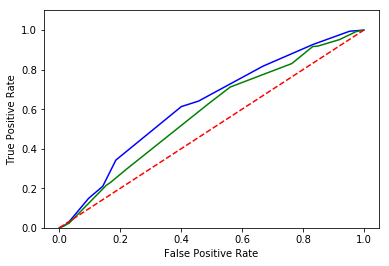

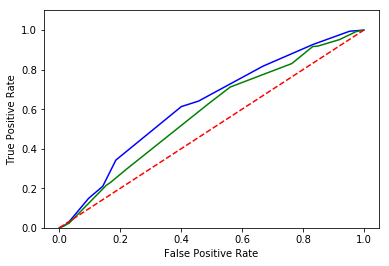

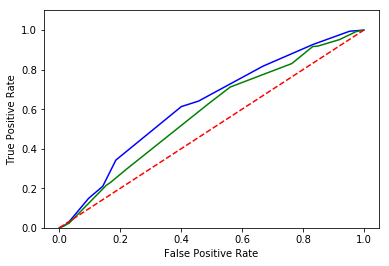

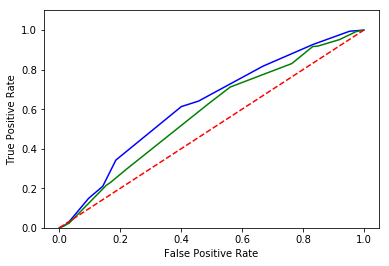

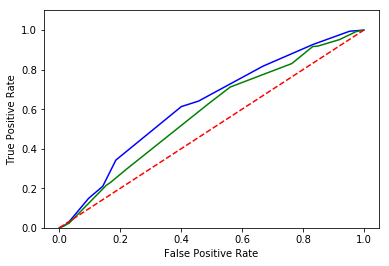

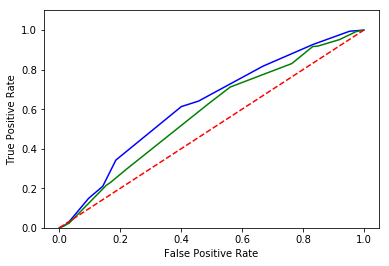

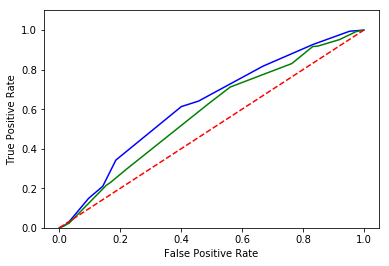

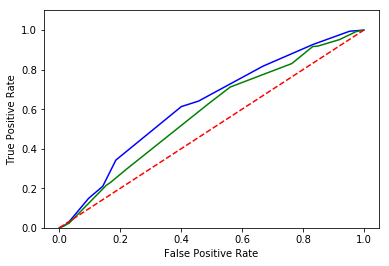

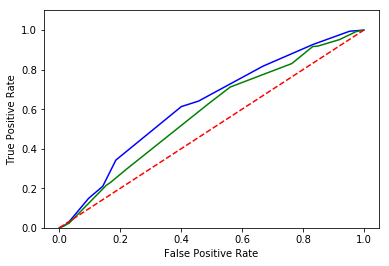

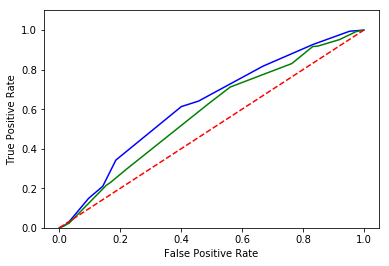

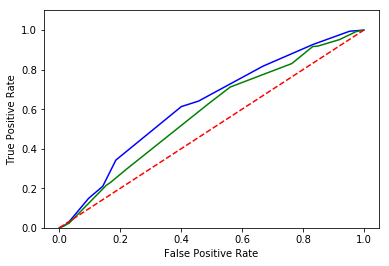

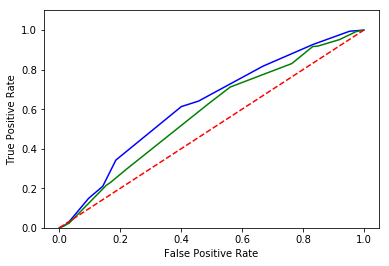

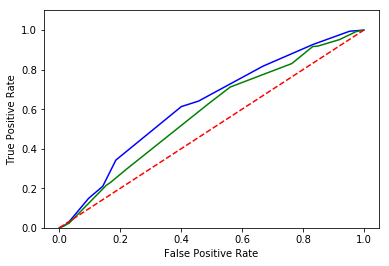

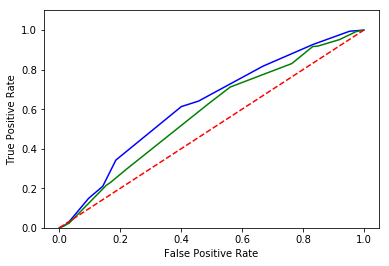

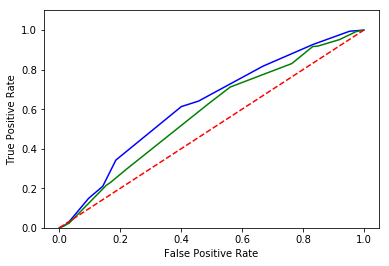

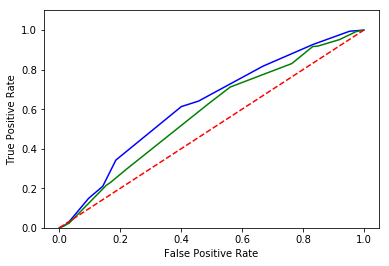

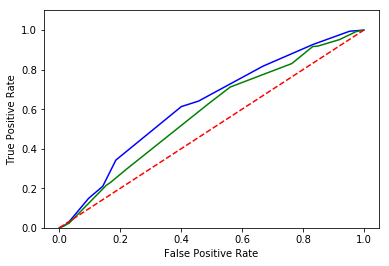

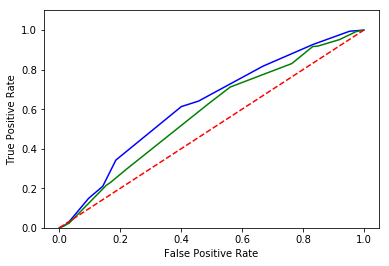

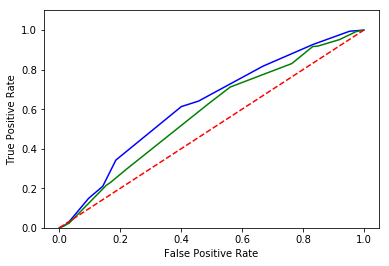

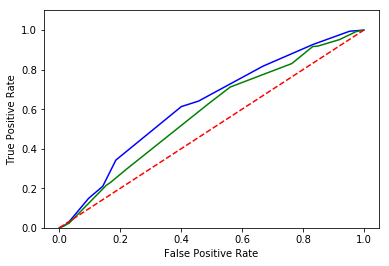

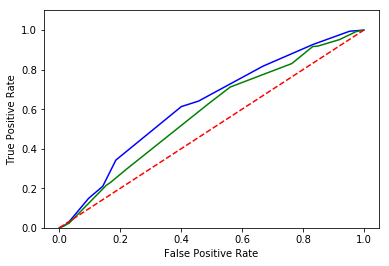

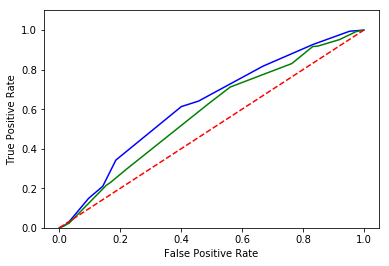

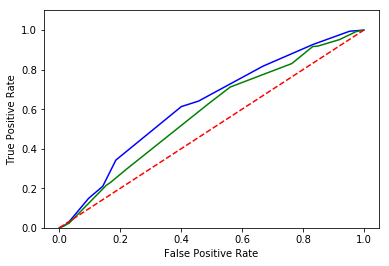

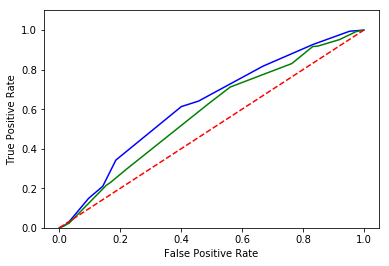

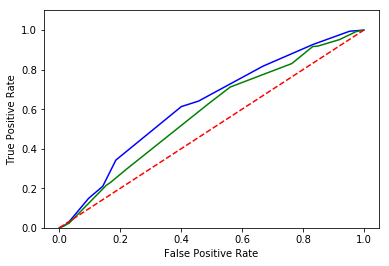

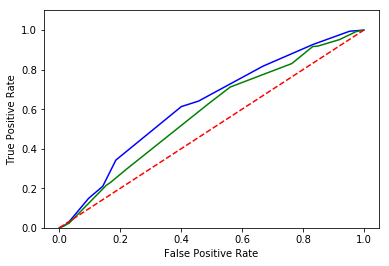

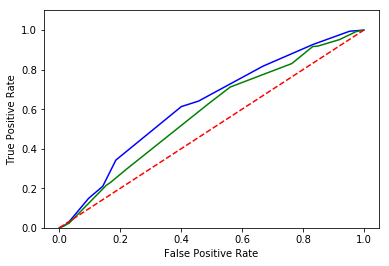

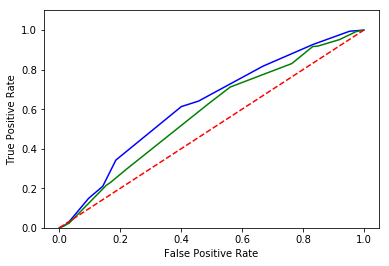

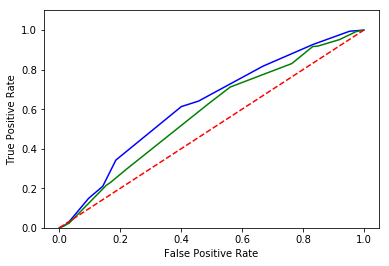

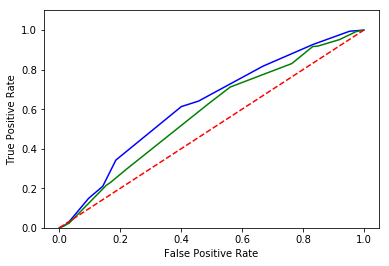

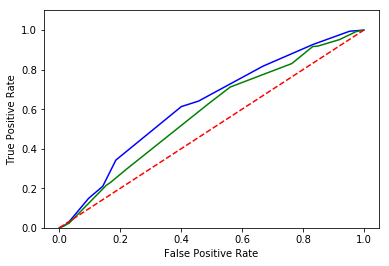

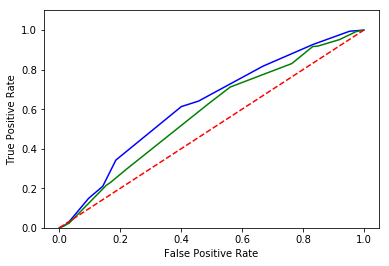

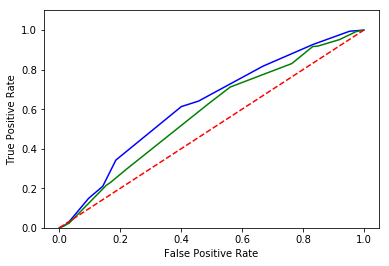

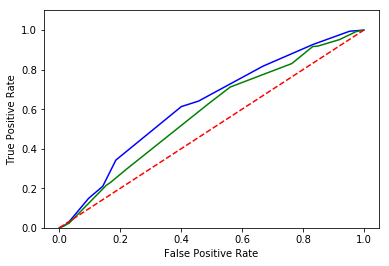

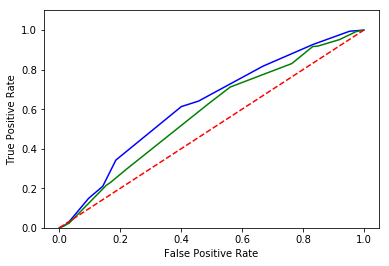

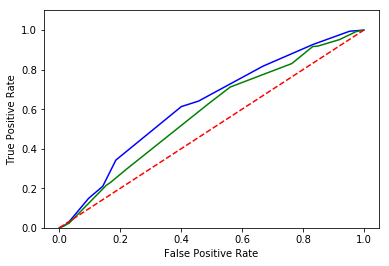

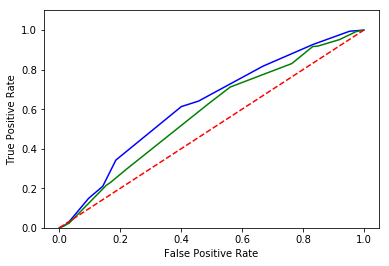

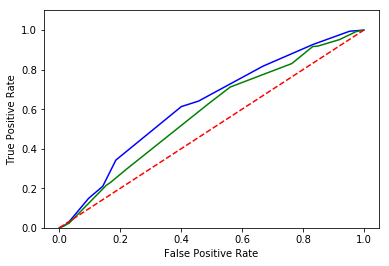

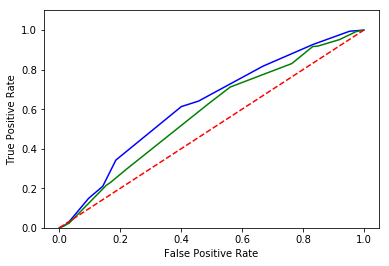

In [46]:
BiasCorrection(1000, torch.tensor(rf_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(rf_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Logistic Regression

In [47]:
logreg_model = Classification(Xcattrain, ytrain, LogisticRegression())
logreg_model.Validate(logreg_model.model, Xcat_white, y_white)
# Test for bias
lr_white_test = Classification(Xcattrain, ytrain, LogisticRegression())
lr_black_test = Classification(Xcattrain, ytrain, LogisticRegression())
lr_white_test.Validate(logreg_model.model, Xcat_white, y_white)
lr_black_test.Validate(logreg_model.model, Xcat_black, y_black)

Accuracy of the model:  0.6252587991718427
[[302   0]
 [181   0]]
[[0.49105691 0.        ]
 [0.29430894 0.        ]]

Accuracy of the model:  0.6252587991718427
[[302   0]
 [181   0]]
[[0.49105691 0.        ]
 [0.29430894 0.        ]]

Accuracy of the model:  0.5890227576974565
[[121 230]
 [ 77 319]]
[[0.19674797 0.37398374]
 [0.12520325 0.51869919]]



# Bias Correction for Logistic Regression

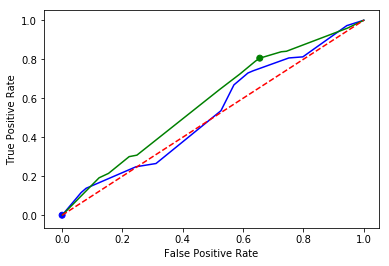

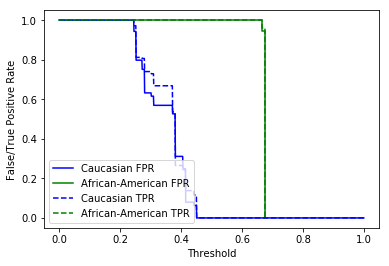

interactive(children=(IntSlider(value=499, description='j', max=991, min=8), Output()), _dom_classes=('widget-…

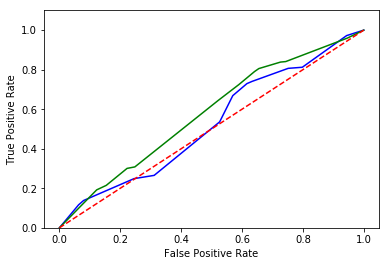

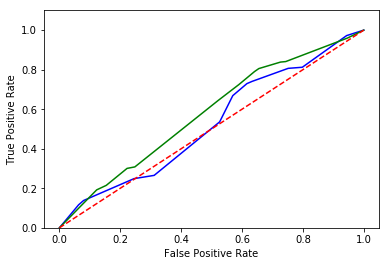

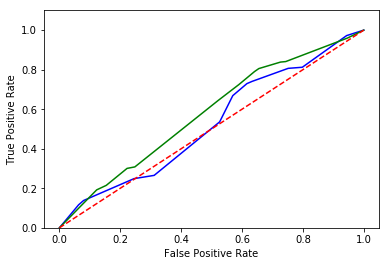

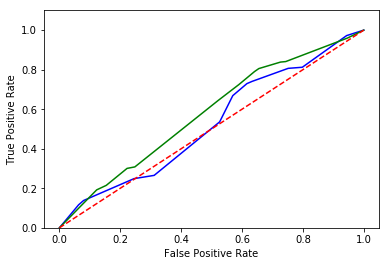

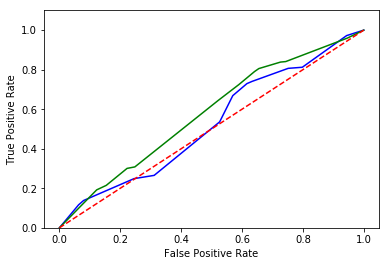

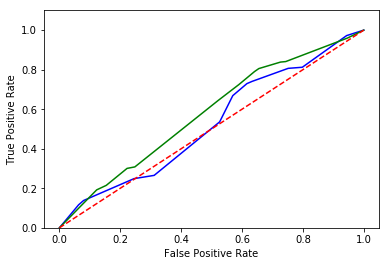

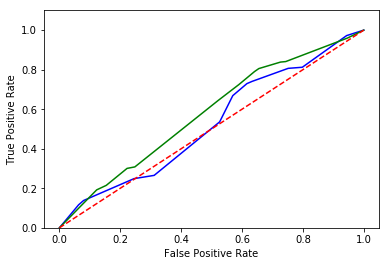

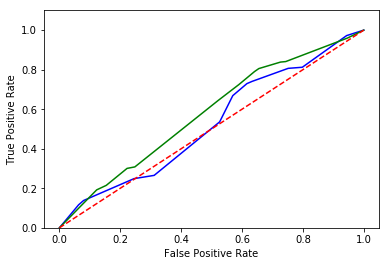

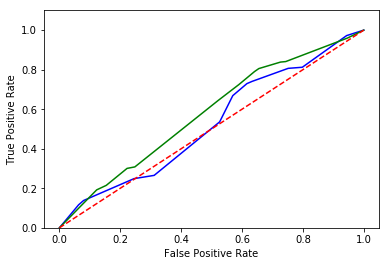

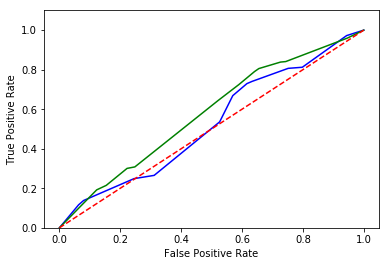

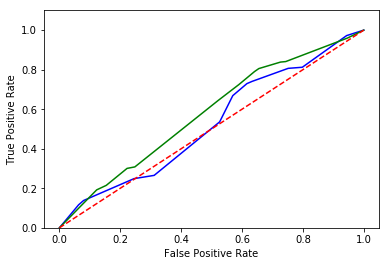

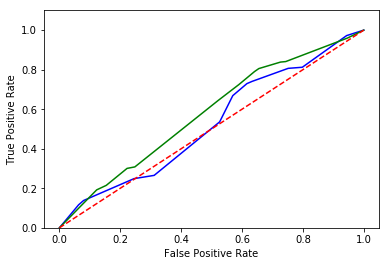

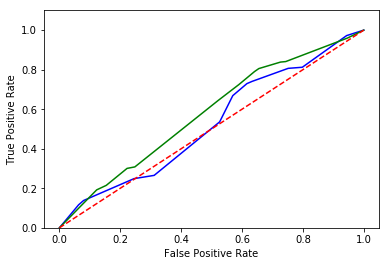

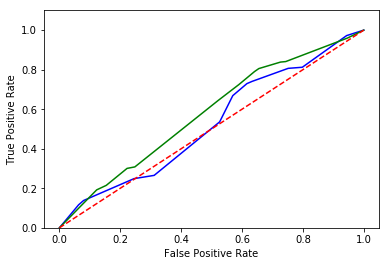

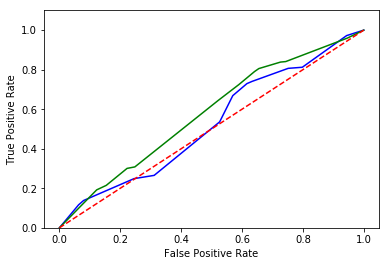

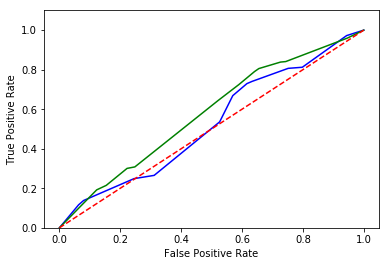

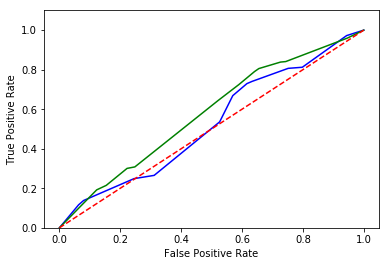

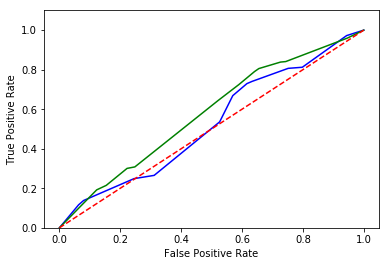

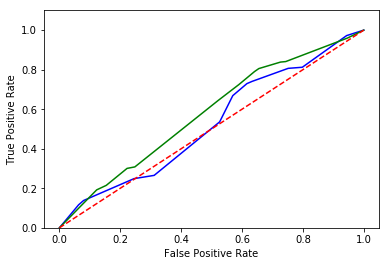

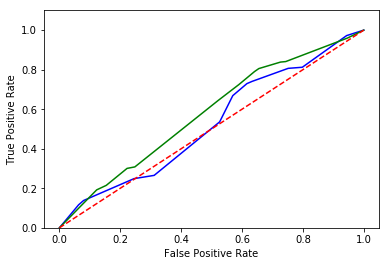

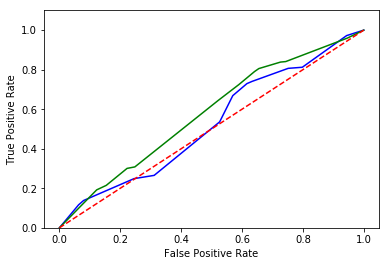

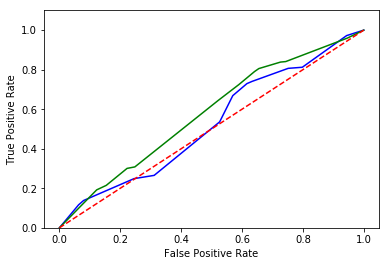

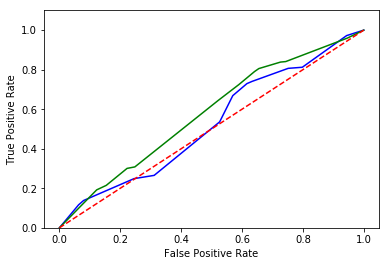

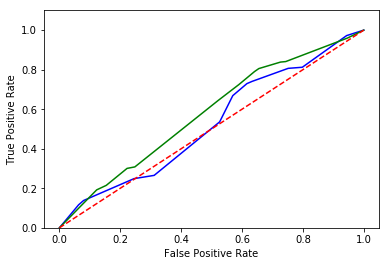

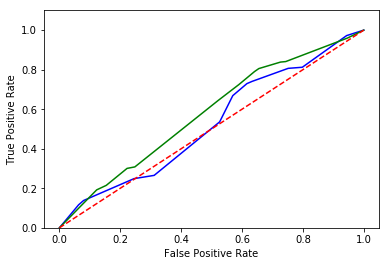

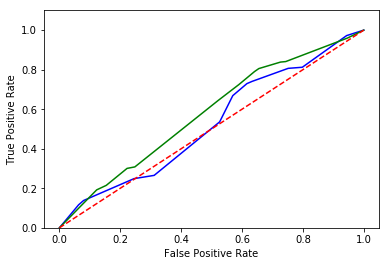

In [48]:
BiasCorrection(1000, torch.tensor(lr_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(lr_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Gaussian Naive Bayes

In [75]:
naive_model = Classification(Xcattrain, ytrain, GaussianNB())
naive_model.Validate(naive_model.model, Xcat_white, y_white)

# Test for bias
nb_white_test = Classification(Xcattrain, ytrain, GaussianNB())
nb_black_test = Classification(Xcattrain, ytrain, GaussianNB())
nb_white_test.Validate(naive_model.model, Xcat_white, y_white)
nb_black_test.Validate(naive_model.model, Xcat_black, y_black)

Accuracy of the model:  0.6294736842105263
[[274  23]
 [153  25]]
[[0.37177748 0.0312076 ]
 [0.21702128 0.03546099]]

Accuracy of the model:  0.6294736842105263
[[274  23]
 [153  25]]
[[0.37177748 0.0312076 ]
 [0.21702128 0.03546099]]

Accuracy of the model:  0.5887096774193549
[[120 229]
 [ 77 318]]
[[0.16282225 0.31071913]
 [0.10921986 0.45106383]]



# Bias Correction for Gaussian Naive Bayes

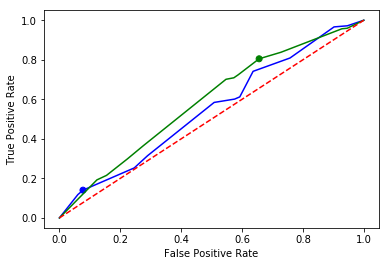

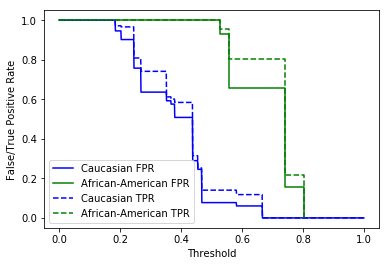

0.711 0.804 0.642840973401245


In [76]:
BiasCorrection(1000, torch.tensor(nb_white_test.probs, dtype = torch.float).reshape(-1, 1), torch.tensor(nb_black_test.probs, dtype = torch.float).reshape(-1, 1), y_white, y_black, show_scatter = True, show_plot = True)

# Temp Bayesian Optimization

In [94]:
## define the domain of the considered parameters
n_estimators = tuple(np.arange(1,101,1, dtype= np.int))
# print(n_estimators)
max_depth = tuple(np.arange(10,110,10, dtype= np.int))
# max_features = ('log2', 'sqrt', None)
max_features = (0, 1)
# criterion = ('gini', 'entropy')
criterion = (0, 1)


# define the dictionary for GPyOpt
domain = [{'n_estimators': 'var_1',  'type': 'discrete',     'domain': n_estimators},
          {'max_depth': 'var_2',     'type': 'discrete',     'domain': max_depth},
          {'max_features': 'var_3',  'type': 'categorical',  'domain': max_features},
          {'criterion': 'var_4',     'type': 'categorical',  'domain': criterion}]


## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    param = param.astype(int)
    
    if param[2] == 0:
        var_3 = "log2"
    else:
        var_3 = "sqrt"
    
    if param[3] == 0:
        var_4 = "gini"
    else:
        var_4 = "entropy"
    
    #fit the model
    model = RandomForestClassifier(n_estimators = param[0], criterion = var_4, max_depth = param[1], max_features = var_3).fit(Xcattrain, ytrain)
    preds = model.predict(Xcattest)
    acc = accuracy_score(ytest, preds)
    print(acc)
    return acc


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 15) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
    x_best[2])  + ", criterion=" + str(
    x_best[3]))

[[94. 70.  0.  0.]]
0.5902439024390244
[[32. 60.  0.  0.]]
0.5902439024390244
[[86. 40.  0.  0.]]
0.5902439024390244
[[29. 80.  0.  1.]]
0.5902439024390244
[[43. 70.  0.  0.]]
0.5902439024390244
[[14. 20.  0.  0.]]
0.5902439024390244
[[31. 60.  1.  1.]]
0.5902439024390244
[[23. 50.  1.  0.]]
0.5902439024390244
[[68. 40.  1.  0.]]
0.5902439024390244
[[11. 70.  1.  1.]]
0.5910569105691057
[[38. 90.  0.  1.]]
0.5902439024390244
[[35. 50.  1.  1.]]
0.5902439024390244
[[24. 30.  1.  0.]]
0.5813008130081301
[[26. 30.  1.  0.]]
0.5902439024390244
[[66. 60.  0.  1.]]
0.5902439024390244
[[92. 80.  0.  1.]]
0.5902439024390244
[[68. 10.  1.  0.]]
0.5902439024390244
[[23. 60.  0.  1.]]
0.5910569105691057
[[10. 10.  0.  0.]]
0.5902439024390244
[[ 14. 100.   1.   1.]]
0.5902439024390244
The best parameters obtained: n_estimators=24.0, max_depth=30.0, max_features=1.0, criterion=0.0


# Bayesian Optimization (Gemt for hyperparameters og ACTIV)

In [ ]:
ACTIV = {0: torch.nn.Tanh(),
         1: torch.nn.ReLU(),
         2: torch.nn.ReLU6(),
         3: torch.nn.Sigmoid(),
        }

netsize = 246

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(x): 
    model = Model(categorical_embedding_sizes, 4, 1, [16,32,64,128,64], p=0.5)
    print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    
    param = x[0]
    hyperparameters = {
        'hidden_units_1': int(np.ceil(param[0]*netsize*0.125)+int(10)),
        'hidden_units_2': int(np.ceil(param[0]*netsize*0.25)+int(10)),
        'hidden_units_3': int(np.ceil(param[0]*netsize*0.5)+int(10)),
        'hidden_units_4': int(np.ceil(param[0]*netsize)+int(10)),
        'hidden_units_5': int(np.ceil(param[0]*netsize*0.5)+int(10)),
        'p': param[1],
        'activation_func': ACTIV[int(param[2])]
    }
    print(hyperparameters)
    trained_model, neural_acc  = train_model(hyperparameters, model)
    print(neural_acc)
    return -neural_acc
    
# define the dictionary for GPyOpt
domain = [{'hidden_units'   : 'var_1', 'type': 'continuous', 'domain': (0 , 1)},
          {'p'              : 'var_2', 'type': 'continuous',  'domain': (0 , 1)},
          {'activation_func': 'var_3', 'type': 'categorical','domain': tuple(np.arange(4))}]


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 100) 


x_best = opt.X[np.argmin(opt.Y)]
print("bedste: ", x_best)
#print("The best parameters obtained: n_estimators=" + str(x_best[0]) + ", max_depth=" + str(x_best[1]) + ", max_features=" + str(
#    x_best[2])  + ", criterion=" + str(
#    x_best[3]))

# Random Forest Feature Importance

Variable: age_cat              Importance: 0.45
Variable: race                 Importance: 0.34
Variable: c_charge_degree      Importance: 0.16
Variable: sex                  Importance: 0.05


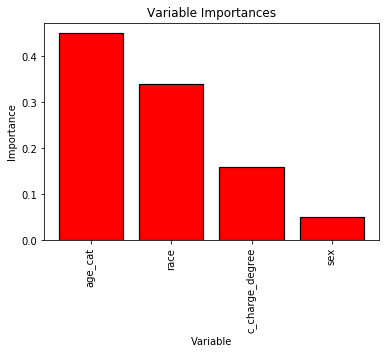

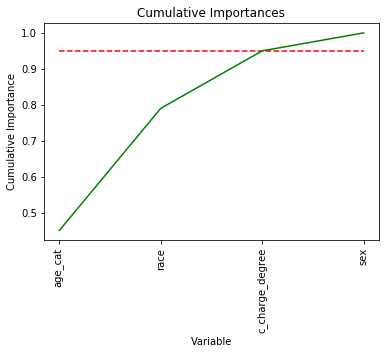

In [157]:
rf_model.FeatureImportance(rf_model.model)